# Skip-Gram Embeddings

> **Note**: This notebook is compatible with both Google Colab and local Jupyter environments. Colab-specific sections are clearly marked.

This notebook explores word representation learning in the biomedical domain using a Skip-Gram Word2Vec model trained on PubMed abstracts. It begins with custom preprocessing tailored to medical text, including number normalization and lemmatization. The learned embeddings are visualized with UMAP to examine the semantic structure of the vocabulary.

To evaluate embedding quality, the notebook includes:
- Word similarity lookups to inspect local relationships
- Word analogies to assess semantic arithmetic
- A histogram of cosine similarities to analyze overall embedding space density

These results offer insight into how well the model captures meaningful biomedical concepts and relationships, laying the groundwork for downstream NLP tasks such as clustering, classification, or retrieval.

In [39]:
!pip install nltk gensim tqdm swifter umap-learn --no-cache-dir

In [40]:
import sys
import os
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')

    project_path = '/content/drive/MyDrive/NLP_Projects/Week_3/word-embeddings-playground'
    if os.path.exists(project_path):
        os.chdir(project_path)
        print(f"Changed working directory to: {project_path}")
    else:
        raise FileNotFoundError(f"Project path not found: {project_path}")
else:
    print("Not running in Colab — skipping Drive mount.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Changed working directory to: /content/drive/MyDrive/NLP_Projects/Week_3/word-embeddings-playground


## Import Libraries

In [41]:
# import libraries
import pandas as pd
import numpy as np

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

import re
import string
import matplotlib.pyplot as plt
import seaborn as sns

from gensim.models import Word2Vec
import swifter

from tqdm import tqdm

from gensim.models import Word2Vec, KeyedVectors

from umap import UMAP

from sklearn.metrics.pairwise import cosine_similarity

import csv

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [42]:
# load stopwords from NLTK
stop_words = set(stopwords.words('english'))

## Load and Preprocess PubMed Abstracts

This cell loads the PubMed abstracts dataset from a CSV file and drops any missing values in the `Abstract` column to retain only valid text entries.

- **File path:** `./data/pubmed_abstracts.csv`
- **Column used:** `Abstract`
- **Missing values:** Removed using `dropna()`

In [43]:
data = pd.read_csv('./data/pubmed_abstracts.csv')

In [44]:
abstracts = data['Abstract'].dropna()

## Custom Text Cleaning and Tokenization

This cell defines and applies a custom preprocessing pipeline for biomedical abstracts. The goal is to standardize numeric patterns, remove stop words and punctuation, and lemmatize tokens for downstream NLP tasks.

### Components:
- **`replace_numbers(text)`**:  
  Replaces:
  - Decimal points in numbers with `<DOT>` (e.g., `6.8` → `<NUM>.<NUM>`)
  - Fractions and ratios with `<SLASH>` (e.g., `120/80` → `<NUM>/<NUM>`)
  - Whole numbers with `<NUM>`
  The `<DOT>` and `<SLASH>` placeholders are restored after transformation to preserve structure.

- **`custom_tokenizer`**:  
  A regular expression tokenizer that preserves biomedical number formats, such as:
  - 120/80  
  - 6.8  
  - 3.2/1.5  
  - Words and hyphenated terms

- **`clean_text(text)`**:
  - Lowercases the input
  - Applies `replace_numbers`
  - Tokenizes using `custom_tokenizer`
  - Removes stop words and most punctuation
  - Lemmatizes tokens unless they contain `<NUM>`

### Application:
- Two example sentences are printed to show the tokenization output.
- The function is applied to all abstracts using `swifter` for parallelized processing.

> Result: A list of cleaned token sequences for all non-null abstracts, stored in `tokenized_abstracts`.

In [45]:
custom_tokenizer = RegexpTokenizer(r'[a-zA-Z\d<NUM>./]+(?:-[a-zA-Z\d<NUM>./]+)*|<NUM>\.<NUM>/<NUM>\.<NUM>|<NUM>\.<NUM>/<NUM>|<NUM>/<NUM>\.<NUM>|<NUM>/<NUM>|<NUM>\.<NUM>|<NUM>|\w+|')

In [46]:
def replace_numbers(text):
  """
  Replaces standalone numbers and specific numeric patterns in a text string with placeholders.

  - Replaces decimal points between digits (e.g., "6.8") with '<DOT>' temporarily.
  - Replaces slashes between digits (e.g., "120/80") with '<SLASH>' temporarily.
  - Replaces all standalone whole numbers with the token '<NUM>'.
  - Restores the decimal points and slashes after substitution.

  Args:
      text (str): Input text to process.

  Returns:
      str: Text with numeric values standardized using the '<NUM>' placeholder.
    """
  text = re.sub(r'(?<=\d)\.(?=\d)', r'<DOT>', text)
  text = re.sub(r'(?<=\d)/(?=\d)', r'<SLASH>', text)
  text = re.sub(r'\b\d+\b', r'<NUM>', text)
  text = text.replace('<DOT>', '.').replace('<SLASH>', '/')
  return text

In [47]:
def clean_text(text):
  """
  Cleans and tokenizes biomedical or clinical text using custom preprocessing steps.

  Steps:
  1. Converts text to lowercase.
  2. Replaces numeric patterns using `replace_numbers()`.
  3. Tokenizes using a custom regular expression tokenizer designed to preserve biomedical formats.
  4. Removes stop words.
  5. Removes most punctuation (retains periods and slashes).
  6. Lemmatizes tokens unless they contain the '<NUM>' placeholder.

  Args:
      text (str): Raw input text to clean and tokenize.

  Returns:
      List[str]: A list of cleaned and lemmatized tokens.
  """
  lemmatizer = WordNetLemmatizer()

  text = text.lower()
  text = replace_numbers(text)
  tokens = custom_tokenizer.tokenize(text)
  tokens = [t for t in tokens if t not in stop_words]
  tokens = [t for t in tokens if t not in string.punctuation or t in ('.', '/')]
  tokens = [lemmatizer.lemmatize(t) if '<NUM>' not in t else t for t in tokens]
  return tokens

In [48]:
text = "The patient's blood pressure is 120/80 mmHg, and HbA1c is 6.8%."
print('Example Sentence:', text)
print('Cleaned Sentence:', clean_text(text))

Example Sentence: The patient's blood pressure is 120/80 mmHg, and HbA1c is 6.8%.
Cleaned Sentence: ['patient', 'blood', 'pressure', '<NUM>/<NUM>', 'mmhg', 'hba1c', '<NUM>.<NUM>', '.']


In [49]:
text = "The p-value was 0.05, and IL-6 levels were high."
print('Example Sentence:', text)
print('Cleaned Sentence:', clean_text(text))

Example Sentence: The p-value was 0.05, and IL-6 levels were high.
Cleaned Sentence: ['p-value', '<NUM>.<NUM>', 'il-<NUM>', 'level', 'high.']


In [50]:
tokenized_abstracts = abstracts.swifter.apply(clean_text).tolist()

Pandas Apply:   0%|          | 0/9981 [00:00<?, ?it/s]

## Training a Skip-Gram Word2Vec Model

This cell trains a Skip-Gram Word2Vec model on the preprocessed PubMed abstracts using the `gensim` library.

- **Model parameters**:
  - `vector_size=200`: size of each word embedding
  - `window=5`: context window for surrounding words
  - `sg=1`: enables Skip-Gram (vs. CBOW)
  - `min_count=20`: ignores words that appear fewer than 20 times
  - `workers=4`: parallel processing

The trained model and word vectors are saved to the `./results/` directory for reuse.

In [51]:
skipgram_model = Word2Vec(
    vector_size = 200,
    window = 5,
    sg = 1,
    min_count = 20,
    workers = 4,
    seed = 56
)

In [52]:
skipgram_model.build_vocab(tokenized_abstracts)

In [53]:
skipgram_model.train(tokenized_abstracts, total_examples = skipgram_model.corpus_count, epochs = 10)

(13372159, 16092320)

In [54]:
skipgram_model.save('./results/skipgram/skipgram.model')

embeddings = skipgram_model.wv
embeddings.save('./results/skipgram/skipgram.embeddings')

## Visualizing Word Embeddings with UMAP

### Full Vocabulary Projection

This plot visualizes a 2D projection of all word embeddings using UMAP, a dimensionality reduction technique suited for preserving local and global structure.

- **Input**: All learned word vectors from the trained Skip-Gram model
- **UMAP settings**:
  - `n_neighbors=15`, `min_dist=0.1`, `metric='cosine'`
- **Plot**: Words are lightly scattered with a subset of tokens labeled for readability

In [55]:
words = list(embeddings.index_to_key)
vectors = embeddings[words]

In [56]:
reducer = UMAP(n_neighbors = 15, min_dist = 0.1, metric = 'cosine', random_state = 42)
embeddings_2d = reducer.fit_transform(vectors)

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


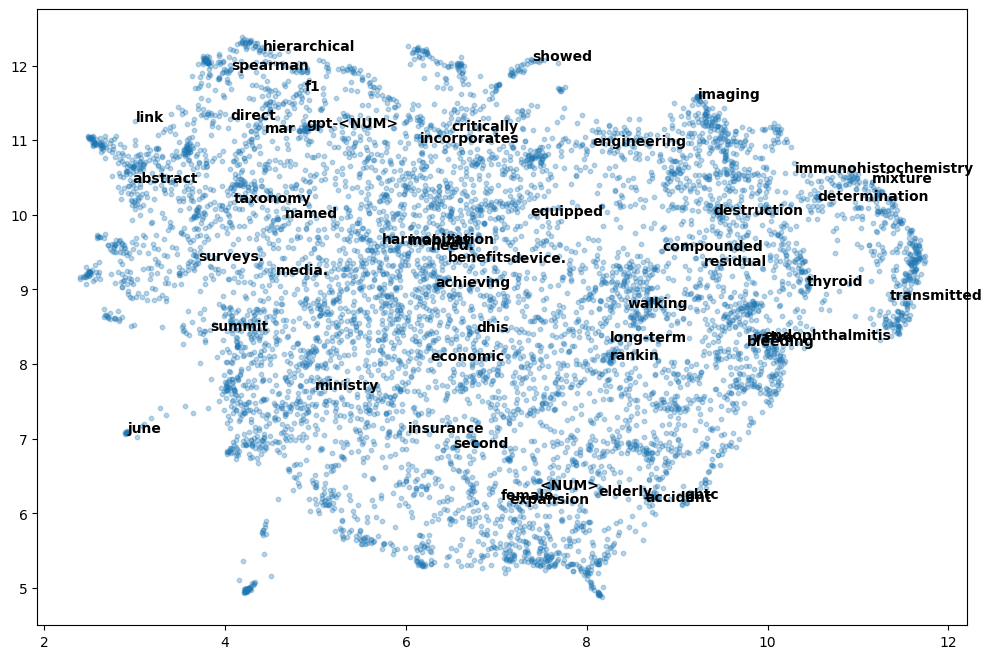

In [57]:
plt.figure(figsize = (12, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha = 0.3, s = 10)

for i in range(0, len(words), max(1, len(words) // 50)):
  plt.text(embeddings_2d[i, 0], embeddings_2d[i, 1], words[i], fontsize = 10, weight = 'bold')

plt.savefig('./results/skipgram/umap_full_vocab.png', dpi = 300, bbox_inches = 'tight')

plt.show()

### Frequent Word Embedding Projection

This plot focuses on the most common words in the corpus (top 5,000 by frequency), providing a cleaner and more interpretable visualization.

- **Input**: Top 5,000 most frequent words and their embeddings
- **UMAP settings**:
  - `n_neighbors=15`, `min_dist=0.1`, `metric='cosine'`
- **Plot**: A dense scatter plot with the 50 most frequent words labeled for clarity

In [58]:
common_words = words[:5000]
common_vectors = embeddings[common_words]

In [59]:
reducer = UMAP(n_neighbors = 15, min_dist = 0.1, metric = 'cosine', random_state = 42)
embeddings_2d = reducer.fit_transform(common_vectors)

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


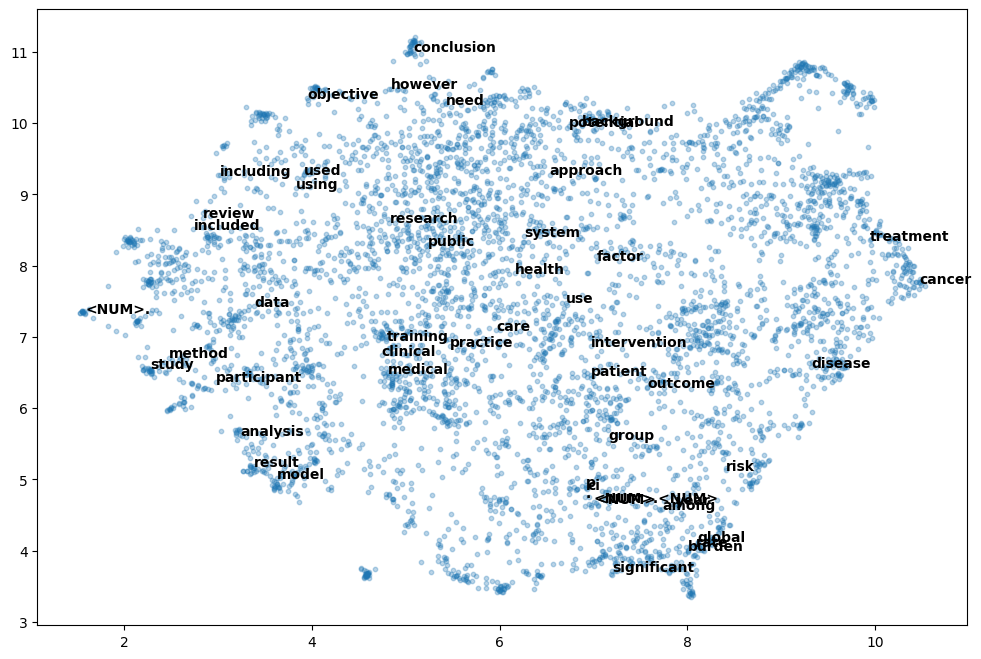

In [60]:
plt.figure(figsize = (12, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha = 0.3, s = 10)

for i in range(0, 50):
  plt.text(embeddings_2d[i, 0], embeddings_2d[i, 1], words[i], fontsize = 10, weight = 'bold')

plt.savefig('./results/skipgram/umap_common_words.png', dpi = 300, bbox_inches = 'tight')

plt.show()

## Explore Similar Words Using Trained Embeddings

This utility prints the top-N most similar words to a given input word based on cosine similarity from the trained Skip-Gram embeddings.

- **Function:** `get_n_similar_words(word, embeddings, n)`
- **Similarity metric:** Cosine distance
- **Examples shown:**  
  - "diabetes"  
  - "cancer"  
  - "disease"  
  - "analysis"  
  - "cardiovascular"

These results help qualitatively evaluate how well the model captures semantic relationships in the biomedical domain.

In [61]:
def get_n_similar_words(word, embeddings, n):
  """
  Prints the top-N most similar words to a given word based on cosine similarity.

  Args:
      word (str): The target word to find similar words for.
      embeddings (gensim KeyedVectors): Trained word embedding model (e.g., Word2Vec.wv).
      n (int): Number of most similar words to retrieve.

  Returns:
      None: Prints the similar words and their similarity scores to the console.
  """
  print(f'{n} Similar Words to {word}:')
  print('-----------------------------')
  similar_words = embeddings.most_similar(word, topn = n)
  for w, s in similar_words:
    print(f'{w}: {s}')

In [62]:
get_n_similar_words('diabetes', embeddings, 10)

10 Similar Words to diabetes:
-----------------------------
mellitus: 0.7541176080703735
diabetes.: 0.6605831980705261
t2d: 0.6361973285675049
t1dm: 0.6161059737205505
t2dm: 0.6013517379760742
hypertension: 0.5927544832229614
dm: 0.5826414227485657
t1d: 0.5802676677703857
ckd: 0.5658411383628845
ncds: 0.5379528403282166


In [63]:
get_n_similar_words('cancer', embeddings, 10)

10 Similar Words to cancer:
-----------------------------
breast: 0.6728115081787109
cancer.: 0.6615035533905029
prostate: 0.6281672120094299
cancers.: 0.6234068870544434
squamous: 0.5896998643875122
pancreatic: 0.577638566493988
non-small: 0.5608282685279846
malignancy: 0.5493006110191345
bc: 0.5427036881446838
adenocarcinoma: 0.5422918796539307


In [64]:
get_n_similar_words('disease', embeddings, 10)

10 Similar Words to disease:
-----------------------------
disease.: 0.5945860147476196
autoimmune: 0.5823320746421814
rheumatoid: 0.5718375444412231
diseases.: 0.5603888630867004
non-communicable: 0.5543056726455688
gout: 0.539929211139679
pancreatitis: 0.537240743637085
parasitic: 0.5254680514335632
atherosclerosis: 0.5208169221878052
masld: 0.5168077945709229


In [65]:
get_n_similar_words('analysis', embeddings, 10)

10 Similar Words to analysis:
-----------------------------
analysis.: 0.577204167842865
analyses.: 0.5651476979255676
kruskal-wallis: 0.5500653386116028
one-way: 0.5478079319000244
chi-squared: 0.5219345688819885
spss: 0.5199634432792664
stata: 0.5171847343444824
vosviewer: 0.5043877959251404
bivariate: 0.5038520097732544
analysed: 0.5002695322036743


In [66]:
get_n_similar_words('cardiovascular', embeddings, 10)

10 Similar Words to cardiovascular:
-----------------------------
atherosclerotic: 0.6119703650474548
cardiometabolic: 0.5622159242630005
cardiac: 0.5390944480895996
ascvd: 0.5367102026939392
cvd: 0.5210939645767212
thrombosis: 0.5153216123580933
cv: 0.4872216284275055
cerebrovascular: 0.4747588634490967
arrhythmia: 0.4721687138080597
heart: 0.4683195650577545


In [67]:
with open('./results/skipgram/similar_words_output.csv', 'w', newline = '') as f:
    writer = csv.writer(f)
    writer.writerow(['Target Word', 'Similar Word', 'Similarity'])
    for word in ['diabetes', 'cancer', 'disease', 'analysis', 'cardiovascular']:
        similar_words = embeddings.most_similar(word, topn = 10)
        for w, s in similar_words:
            writer.writerow([word, w, round(s, 4)])

## Cosine Similarity Distribution Between Word Embeddings

This plot shows the distribution of pairwise cosine similarities between all word embeddings in the vocabulary.

- **Input**: Cosine similarity matrix for all word vectors
- **Processing**: Only upper triangle values (excluding diagonal) are used to avoid duplicates
- **Plot**: Histogram of similarity scores

This helps evaluate how tightly clustered or dispersed the learned embedding space is.

In [68]:
similarities = cosine_similarity(vectors, vectors)

upper_i, upper_j = np.triu_indices(similarities.shape[0], k = 1)
similarities = similarities[upper_i, upper_j]

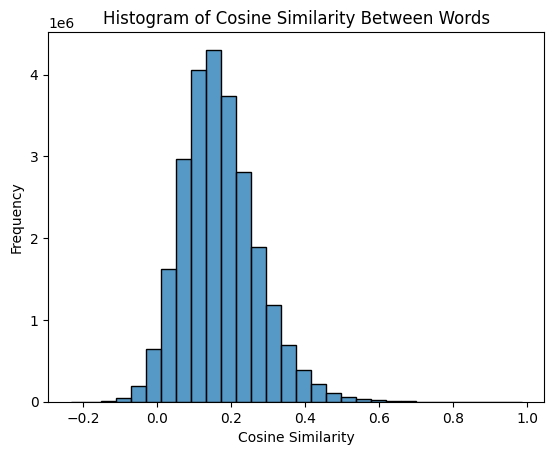

In [69]:
sns.histplot(similarities, bins = 30, kde = False)
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.title('Histogram of Cosine Similarity Between Words')
plt.savefig('./results/skipgram/cosine_similarity_histogram.png', dpi = 300, bbox_inches = 'tight')
plt.show()

## Word Analogy Exploration

This section uses vector arithmetic to explore analogies in the embedding space using the `most_similar` method from `gensim`.

- **Function:** `get_analogy(positives, negatives, embeddings, n)`
- **Purpose:** Answers analogies of the form:
  > *A is to B as C is to ?*

### Examples:
- heart → cardiovascular :: lung → ?
- bacteria → antibiotic :: virus → ?
- psychiatry → mental :: cardiology → ?
- cancer → oncology :: pneumonia → ?

These examples demonstrate how well the model captures abstract semantic and domain-specific relationships in biomedical language.

In [70]:
def get_analogy(positives, negatives, embeddings, n):
  """
  Solves word analogies using vector arithmetic in the embedding space.

  Example: If negatives = ['diabetes'], positives = ['insulin', 'asthma'],
  the function answers: "diabetes is to insulin as asthma is to ?"

  Args:
      positives (List[str]): Words to add in the analogy (e.g., ['insulin', 'asthma']).
      negatives (List[str]): Word(s) to subtract in the analogy (e.g., ['diabetes']).
      embeddings (gensim KeyedVectors): Trained word embedding model (e.g., Word2Vec.wv).
      n (int): Number of most similar words to return.

  Returns:
      None: Prints the analogy result and top-n most similar words with similarity scores.
  """
  print(f'{negatives[0]} is to {positives[0]} as {positives[1]} is to:')
  print('---------------------------------------------------')
  results = embeddings.most_similar(positive = positives, negative = negatives, topn = n)
  for w, s in results:
    print(f'{w}: {s}')

In [71]:
get_analogy(positives = ['cardiovascular', 'lung'], negatives = ['heart'], embeddings = embeddings, n = 5)

heart is to cardiovascular as lung is to:
---------------------------------------------------
bladder: 0.47419223189353943
non-small: 0.45257845520973206
endometrial: 0.40944522619247437
breast: 0.4071893095970154
hereditary: 0.3949638903141022


In [72]:
get_analogy(positives = ['antibiotic', 'virus'], negatives = ['bacteria'], embeddings = embeddings, n = 5)

bacteria is to antibiotic as virus is to:
---------------------------------------------------
rsv: 0.5005531311035156
antiviral: 0.47883835434913635
influenza: 0.4732479155063629
prophylaxis: 0.4682873785495758
pertussis: 0.43217232823371887


In [73]:
get_analogy(positives = ['mental', 'cardiology'], negatives = ['psychiatry'], embeddings = embeddings, n = 5)

psychiatry is to mental as cardiology is to:
---------------------------------------------------
cardiovascular: 0.38929682970046997
diabetes: 0.3880345821380615
rheumatic: 0.3829456865787506
acp: 0.3804444968700409
rhythm: 0.375268816947937


In [74]:
get_analogy(positives = ['oncology', 'pneumonia'], negatives = ['cancer'], embeddings = embeddings, n = 5)

cancer is to oncology as pneumonia is to:
---------------------------------------------------
pseudomonas: 0.448874294757843
fever: 0.4458121061325073
streptococcus: 0.43651649355888367
enterobacterales: 0.43002018332481384
uti: 0.41788148880004883


In [75]:
analogy_queries = [
    (['cardiovascular', 'lung'], ['heart']),
    (['antibiotic', 'virus'], ['bacteria']),
    (['mental', 'cardiology'], ['psychiatry']),
    (['oncology', 'pneumonia'], ['cancer']),
]

with open('./results/skipgram/analogy_results.csv', 'w', newline = '') as f:
    writer = csv.writer(f)
    writer.writerow(['Analogy', 'Predicted Word', 'Similarity'])

    for positives, negatives in analogy_queries:
        analogy_str = f"{negatives[0]} is to {positives[0]} as {positives[1]} is to"
        results = embeddings.most_similar(positive = positives, negative = negatives, topn = 5)
        for w, s in results:
            writer.writerow([analogy_str, w, round(s, 4)])